In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

2023-10-07 10:42:14.237212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 10:42:14.237263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 10:42:14.237291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 10:42:14.246055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [10]:
def dy(x, y):
    return dde.grad.jacobian(y, x)

def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return dy(x, ddy(x, y))

In [11]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1

In [12]:
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [13]:
geom = dde.geometry.Interval(0, 1)

bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left)
bc2 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y), boundary_left)
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_right)
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_right)

def true_solution(x):
    return -(x**4)/24 + (x**3)/6 - (x**2)/4

data = dde.data.PDE(geom,
                    pde,
                    [bc1, bc2, bc3, bc4],
                    num_domain = 10,
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

In [14]:
layer_size = [1] + [20]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

In [15]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.006781 s



Training model...

Cause: could not parse the source code of <function <lambda> at 0x7fbe846c0790>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fbe846c0790>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-10-07 10:52:11.099798: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c34f0ca3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 10:52:11.099851: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-07 10:52:11.124181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 10:52:11.853944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-07 10:52:11.884800: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-07 10:52:12.451328: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [4.27e-01, 0.00e+00, 1.02e-01, 1.23e-02, 5.74e-03]    [3.84e-01, 0.00e+00, 1.02e-01, 1.23e-02, 5.74e-03]    []  
1000      [1.37e-04, 9.58e-10, 3.59e-08, 4.07e-07, 4.68e-07]    [1.09e-04, 9.56e-10, 3.60e-08, 4.07e-07, 4.67e-07]    []  
2000      [4.87e-05, 4.70e-10, 1.38e-09, 2.66e-08, 7.69e-09]    [5.51e-05, 4.67e-10, 1.38e-09, 2.66e-08, 7.71e-09]    []  
3000      [3.65e-05, 1.54e-10, 2.29e-11, 1.69e-08, 1.65e-09]    [4.38e-05, 1.57e-10, 2.23e-11, 1.69e-08, 1.66e-09]    []  
4000      [2.89e-05, 2.20e-11, 6.05e-10, 8.07e-09, 2.76e-09]    [3.56e-05, 2.26e-11, 6.12e-10, 8.05e-09, 2.78e-09]    []  
5000      [2.33e-05, 3.51e-10, 1.10e-09, 3.84e-09, 2.36e-10]    [2.86e-05, 3.58e-10, 1.11e-09, 3.82e-09, 2.32e-10]    []  

Best model at step 5000:
  train loss: 2.33e-05
  test loss: 2.86e-05
  test metric: []

'train' took 14.145578 s



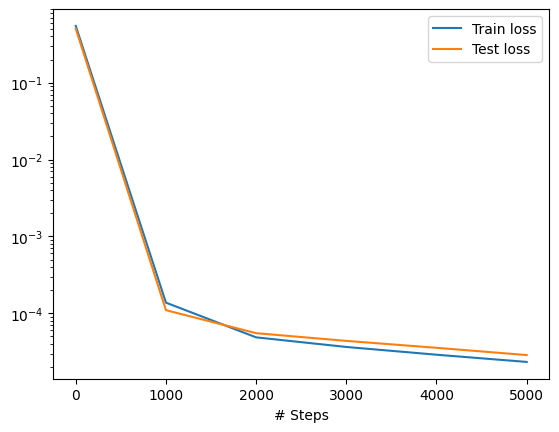

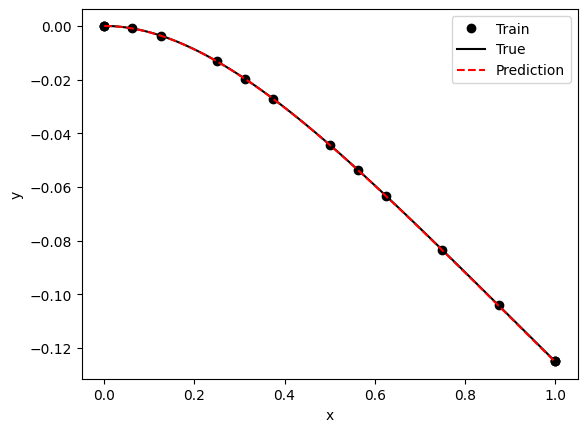

In [16]:
losshistory, train_state = model.train(iterations=5000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)